In [1]:
import localcider
from localcider.sequenceParameters import SequenceParameters
import protfasta
import glob
import pandas as pd
import numpy as np
import re
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict 
from Bio.Seq import Seq
import Bio
import matplotlib.patches as mpatches
import seaborn as sns
import metapredict as meta


In [2]:
masterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20220726_readthresh_10.csv')
# rename the BYS2 second sequencing run activity value. These data are 
# masterDF['Activity_SCglucose_BYS2_Bowtie'] = masterDF.Activity_SCglucose

# # integrate perfect match activity data from Jordan 20230130
# perfectMatchActivity = pd.read_csv('../Data/Sort2_SequencingData_202207/SC_glucose_Ratio_8bins_reprocessWperfectmatches/GCN4_ratio_v2_perfect_matches.csv')
# dna = masterDF.ArrayDNA
# tempDict = dict(zip(perfectMatchActivity.ArrayDNA,perfectMatchActivity.activity_gcn4_ratio_v2_pm))
# masterDF['Activity_SCglucose_BYS2_PerfectMatch'] = dna.map(tempDict)
# masterDF['Activity_SCglucose']=masterDF['Activity_SCglucose_PerfectMatch']
masterDF = masterDF[['ADseq','Name','ArrayDNA']]

In [3]:
# add the data for the two biological replicates
# colRenameDict = {'Activity_A':'Activity_BioRepA_BYS4', 'Activity_B':'Activity_BioRepB_BYS4',
#                  'reads_A':'TotalReads_BioRepA_BYS4', 'reads_B':'TotalReads_BioRepB_BYS4', 
#                  'avg':'Activity_BYS4_BioRepAverage','std':'Stdev_BYS4_BioReps'}
# DeepSeq2BioReps = pd.read_csv('../Data/ReproducibilitySort/gcn4_deep.csv') #before 20240522
# DeepSeq2BioReps = pd.read_csv('../Data/ReproducibilitySort/gcn4_deep.csv') #updated 20240522 No change made

# tempSeries = masterDF.ArrayDNA
# for col in ['Activity_A', 'Activity_B', 'reads_A', 'reads_B', 'avg','std']:
#     tempDict = dict(zip(DeepSeq2BioReps.ArrayDNA,DeepSeq2BioReps[col]))
#     masterDF[colRenameDict[col]]=tempSeries.map(tempDict)


# M. Zintel reprocessing of the data for publication
tileDF_MZ = pd.read_csv('../Data/Zintel_Reprocess202409/BYS4combined_bothredoseqsincluded.csv')

colRenameDict = {'numreads_per_AD_1AGFP':'BioRep_A_GFP_TotalReads',    
                 'Activity_1AGFP':'BioRep_A_GFP',
                 'numreads_per_AD_2AmCh':'BioRep_A_mCherry_TotalReads',    
                 'Activity_2AmCh':'BioRep_A_mCherry',
                 'numreads_per_AD_3ARatio_redoseq_original':'TotalReads_BioRepA_BYS4',       
                 'Activity_3ARatio_redoseq_original':'Activity_BioRepA_BYS4',             
                 'numreads_per_AD_4BGFP':'BioRep_B_GFP_TotalReads',    
                 'Activity_4BGFP':'BioRep_B_GFP',  
                 'numreads_per_AD_5BmCh':'BioRep_B_mCherry_TotalReads',    
                 'Activity_5BmCh':'BioRep_B_mCherry',            
                 'numreads_per_AD_6BRatio_redoseq_original':'TotalReads_BioRepB_BYS4',       
                 'Activity_6BRatio_redoseq_original':'Activity_BioRepB_BYS4',}

tempSeries = masterDF.ArrayDNA
for col in ['Activity_3ARatio_redoseq_original', 
            'Activity_6BRatio_redoseq_original',
            'numreads_per_AD_3ARatio_redoseq_original',
            'numreads_per_AD_6BRatio_redoseq_original', 
            'numreads_per_AD_1AGFP',    'Activity_1AGFP',
            'numreads_per_AD_4BGFP',    'Activity_4BGFP',
            'numreads_per_AD_2AmCh',    'Activity_2AmCh',
            'numreads_per_AD_5BmCh',    'Activity_5BmCh',           ]:
    tempDict = dict(zip(tileDF_MZ.DNAseq,tileDF_MZ[col]))
    masterDF[colRenameDict[col]]=tempSeries.map(tempDict)
masterDF.columns

Index(['ADseq', 'Name', 'ArrayDNA', 'Activity_BioRepA_BYS4',
       'Activity_BioRepB_BYS4', 'TotalReads_BioRepA_BYS4',
       'TotalReads_BioRepB_BYS4', 'BioRep_A_GFP_TotalReads', 'BioRep_A_GFP',
       'BioRep_B_GFP_TotalReads', 'BioRep_B_GFP',
       'BioRep_A_mCherry_TotalReads', 'BioRep_A_mCherry',
       'BioRep_B_mCherry_TotalReads', 'BioRep_B_mCherry'],
      dtype='object')

<AxesSubplot:xlabel='Activity_1AGFP', ylabel='Activity_4BGFP'>

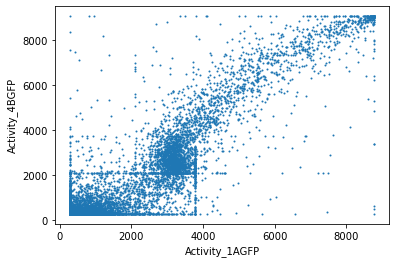

In [4]:
tileDF_MZ.plot.scatter(x='Activity_1AGFP',y='Activity_4BGFP',s=1)

<AxesSubplot:xlabel='BioRep_A_GFP', ylabel='BioRep_B_GFP'>

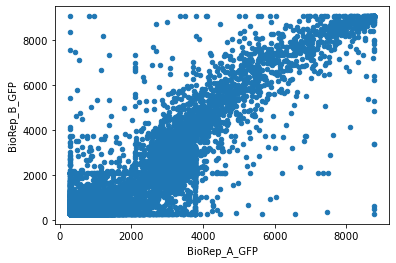

In [5]:
masterDF.plot.scatter(x='BioRep_A_GFP',y='BioRep_B_GFP')

In [6]:
# 20230414 Use the average of the deep sequencing of the biological replicates 
temp = masterDF[['Activity_BioRepA_BYS4',       'Activity_BioRepB_BYS4']]
masterDF['Activity_BYS4_BioRepAverage'] = temp.mean(axis=1,skipna=False)
masterDF['Stdev_BioReps']= temp.std(axis=1,skipna=True)

joinedActivities = pd.Series(masterDF.Activity_BYS4_BioRepAverage.values)
holdA = np.zeros_like(joinedActivities)
holdB = np.zeros_like(joinedActivities)
both = sum(joinedActivities>0)
print('%i measured in both bioReps'% both)
joinedActivities[joinedActivities.isna()] = masterDF[joinedActivities.isna()].Activity_BioRepA_BYS4
holdB[joinedActivities.isna()] = masterDF[joinedActivities.isna()].Activity_BioRepA_BYS4
addedbyA = sum(joinedActivities>0)-both
print('%i measured only in BioRep A'%addedbyA)
joinedActivities[joinedActivities.isna()] = masterDF[joinedActivities.isna()].Activity_BioRepB_BYS4
addedbyB = sum(joinedActivities>0)-both-addedbyA
print('%i measured only in BioRep B'%addedbyB)
print('%i missing from both'%joinedActivities.isna().sum())

masterDF['Activity_SCglucose']=joinedActivities


10855 measured in both bioReps
4177 measured only in BioRep A
3915 measured only in BioRep B
1784 missing from both


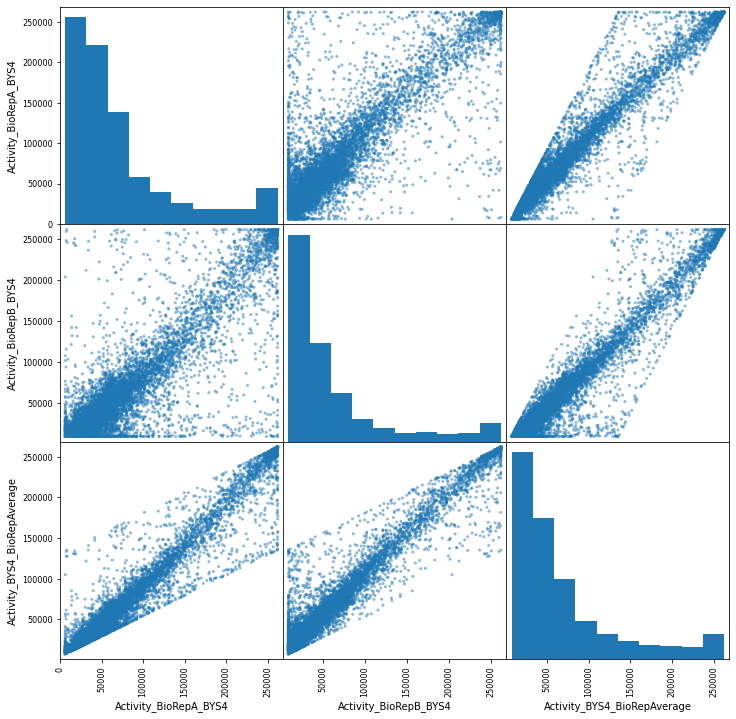

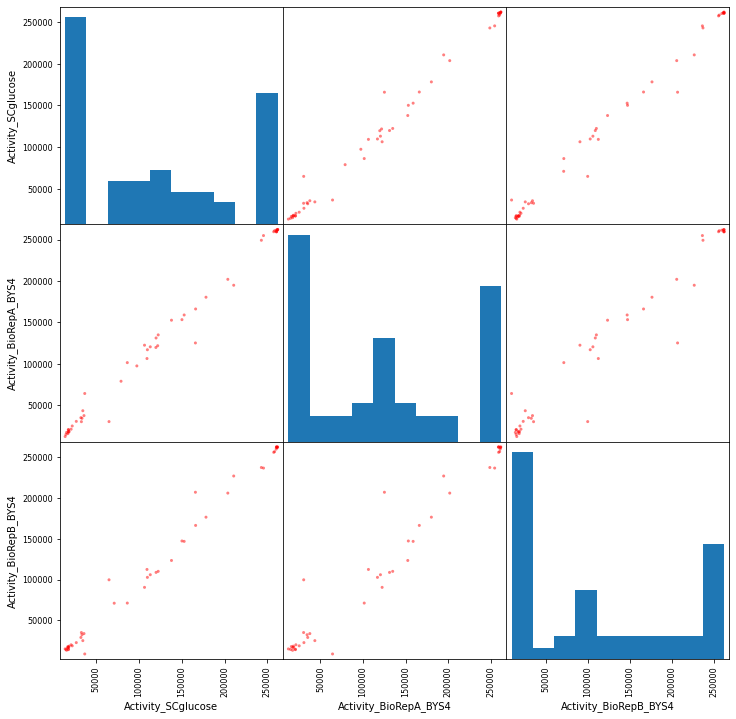

In [7]:
tempDF = masterDF[[#'Activity_SCglucose','Activity_SCglucose_BYS2_PerfectMatch',
                   'Activity_BioRepA_BYS4',
       'Activity_BioRepB_BYS4',
                   'Activity_BYS4_BioRepAverage']]
# The Averaging the two BioReps causes the empty triangles in the corners.  
tempDF.corr()
pd.plotting.scatter_matrix(tempDF, alpha=0.5, figsize=(12,12))
Controls = masterDF[-52:]
tempDF = Controls[['Activity_SCglucose',#'Activity_SCglucose_BYS2_PerfectMatch',
                   'Activity_BioRepA_BYS4',
       'Activity_BioRepB_BYS4']]

tempDF.corr()
pd.plotting.scatter_matrix(tempDF, alpha=0.5, figsize=(12,12),c='red')
plt.show()

In [8]:
print('%i missing from combined BioReps (average and singles)' %sum(np.isnan(masterDF.Activity_SCglucose)))
print('%i missing from original average of the BioReps (only values in both Reps)' %sum(np.isnan(masterDF.Activity_BYS4_BioRepAverage)))

1784 missing from combined BioReps (average and singles)
9876 missing from original average of the BioReps (only values in both Reps)


In [9]:
# sanity check, make sure protein seq matches translation of DNA seq in array.
# added 20221031. There was a label error for VP16N_7As_0 and VP16N_L2A_0. I swapped them and am correcting it here. 
# I am also checking that there aren't other errors.
for i, row in masterDF.iterrows():
    dna = Seq(row.ArrayDNA)
    translation = str(dna.translate())
    protein =row.ADseq
    if protein != translation:
        print( row)
# Array DNA seq always matches the protein. :)

#change the labels of the two swapped designs, VP16N_7As_0 and VP16N_L2A_0
# 20703    VP16N_7As_0 >VP16N_L2A_0
masterDF[20703, 'Name'] = 'VP16N_L2A_0'
# 20705    VP16N_L2A_0 > VP16N_7As_0
masterDF[20707, 'Name'] = 'VP16N_7As_0'


In [10]:
maxActivity = max(masterDF.Activity_SCglucose)
Activity = 'Activity_SCglucose'
masterDF['Start'] = masterDF.Name.str.split('_',expand=False).str[-1]
masterDF['Recovered']=masterDF[Activity]>0
print('%i of %i Designed ADs recovered, %.1f percent'%(sum(masterDF['Recovered']),len(masterDF),100.0*sum(masterDF['Recovered'])/len(masterDF)))


18947 of 20731 Designed ADs recovered, 91.4 percent


In [11]:
# Find the activity threshold
tempDF = masterDF[masterDF.Recovered]
tempDF[Activity].quantile(80/100.0)


94031.10168895355

In [12]:
# sequence features. 
# Calculate bulk properties of full seq
Netcharge = []
hydrophobicities = []
hydrophobicitiesWW =[]
Disorder = []
Kappa =[]
Omega = []
OmegaWFY_DE =[]
OmegaWFYL_DE =[]
OmegaWF_D =[]
# PhosCharge #TO DO add net charge assuming all STY are phosphorylated
for line in masterDF.ADseq: # This analysis includes the leading 'M' from the start codon
    seq =  SequenceParameters(line)
    Netcharge.append(seq.get_NCPR()*len(seq))
    hydrophobicities.append(seq.get_uversky_hydropathy())
    hydrophobicitiesWW.append(seq.get_WW_hydropathy())
    Disorder.append(np.mean(meta.predict_disorder(line))) # add metapredict
    Kappa.append(seq.get_kappa())
    Omega.append(seq.get_Omega())
    OmegaWFY_DE.append(seq.get_kappa_X(['D','E'],['W','F','Y']))
    OmegaWFYL_DE.append(seq.get_kappa_X(['D','E'],['W','F','Y','L']))
    OmegaWF_D.append(seq.get_kappa_X(['D'],['W','F']))

    
masterDF['Charge']=Netcharge
masterDF['HydrophobicityKD']=hydrophobicities
masterDF['HydrophobicityWW']=hydrophobicitiesWW
masterDF['Kappa'] =Kappa
masterDF['Omega'] = Omega
masterDF['OmegaWFY_DE'] =OmegaWFY_DE
masterDF['OmegaWFYL_DE'] =OmegaWFYL_DE
masterDF['OmegaWF_D']    =OmegaWF_D
masterDF['Disorder']=Disorder

#count Key AAs
AAlist = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'];
# AAlist = ['D','E','F','K','L','M','P','R','W','Y'];
for aa in AAlist:
    tempcount =[]
    for i, row in masterDF.iterrows():
        tempseq = row.ADseq
        tempcount.append(tempseq.count(aa))
    masterDF[aa] = tempcount
masterDF['Aromatics'] =masterDF.W+masterDF.Y+masterDF.F
masterDF['WFYL'] =masterDF.W+masterDF.Y+masterDF.F+masterDF.L


# # run MetaPredict on FL TF seqs
# # metapredict.predict_disorder(FullOrthoDF.Seq)
# tempParam = []
# for line in FullOrthoDF.Seq: # This analysis includes the leading 'M' from the start codon
# #     seq =  SequenceParameters(line)
#     tempParam.append(metapredict.predict_disorder(line))
# FullOrthoDF['Disorder'] = tempParam


# countMotifs

In [13]:
def CountMotifs(currentDF, motiflist,column='ADseq',printstats =True, plothist=True):
    for motif in motiflist:
        tempcol = []
        for seq in currentDF[column]:
            hits = re.search(motif,seq)
            if hits:
                matches = re.findall(motif,seq)
                tempcol.append(len(matches))
            else:
                tempcol.append(0)
        currentDF[motif]=tempcol
        if  printstats :
#             plt.hist(currentDF[Activity],150) #Blue hist includes not detected ADs
            indx = (currentDF[motif]>0)&(currentDF.Recovered)
            tempDF  =  currentDF[indx]
            notindx = (currentDF[motif]==0)&(currentDF.Recovered)
            notDF = currentDF[notindx]
            # stats does not use non detected ADs
            test = stats.ttest_ind(tempDF[Activity],notDF[Activity], equal_var=False)
            print(motif)
            print('%.1f (n=%i) with vs %.1f without (%i)\n'%(np.mean(tempDF[Activity]),sum(indx),np.mean(notDF[Activity]),sum((currentDF[motif]==0)&(currentDF.Recovered))))
            print(test)
        if plothist:
            #Blue hist does not use non detected ADs
            plt.hist(notDF[Activity],150,density=True) 
            # orange hist does not use non detected ADs
            plt.hist(tempDF[Activity],150,alpha=.5,density=True)
            plt.savefig('Figures/CompareActivitywMotif_%s.pdf'%motif)
            plt.show()
    return currentDF
motiflist = ['W..LF',
             '[WFYL]..[WFYL][WFYL]',
             '[WFL]..[WFL][WFL]',
             '[DE][WFY]',
             '[DE][WF]',
#              '[DE][LM]','[DE][M]',# not as strong
             '[DE][L]',
             '[DE].[WFY]',
             '[DE]..[WFY]',
             'FF','F.F','F..F',
             '[FY].....[FY]'
#              '[WFYL][WFYL]','[WFYL].[WFYL]','[WFYL]..[WFYL]',
             'DF','D.F','D..F','FD','F.D','F..D',
             'MF.Y..L', 
             'M..Y..L', 
#              '[DE]...[DE]',
#              '[DE]....[DE]',
#              '[DE].....[DE]',
             'SP',
             '[WFYL]...[WFYL][WFYL]',#kix binding motif
#              '[FWYL].[FWYL]..[FWYL]'
#              ACDEFGHIKLMNPQRSTVWY              
            ]
motiflist_publication = ['W..LF',
             '[WFYL]..[WFYL][WFYL]',
             '[DE][WFY]',
             'FF','F.F','F..F',
                         'MF.Y..L',
            ]

# tempDF2 = CountMotifs(tempDF,motiflist)
masterDF = CountMotifs(masterDF,motiflist,printstats =False, plothist=False)

In [ ]:
temp = masterDF[['Activity_BioRepA_BYS4',       'Activity_BioRepB_BYS4']]
masterDF['Activity_BYS4_BioRepAverage'] = temp.mean(axis=1,skipna=False)
masterDF['Stdev_BioReps']= temp.std(axis=1,skipna=True)


In [14]:
masterDF['WFL']=masterDF.W +masterDF.F +masterDF.L
masterDF['WFYLM']=masterDF.WFYL+ masterDF.M
masterDF['WF']=masterDF.W +masterDF.F
masterDF['TotalReads_SCglucose']=masterDF.TotalReads_BioRepA_BYS4+masterDF.TotalReads_BioRepB_BYS4
masterDF.to_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20240930_withSeqFeatures.csv')

In [15]:
# for col in masterDF.columns:
#     print(col)
masterDF.columns

Index([                      'ADseq',                        'Name',
                          'ArrayDNA',       'Activity_BioRepA_BYS4',
             'Activity_BioRepB_BYS4',     'TotalReads_BioRepA_BYS4',
           'TotalReads_BioRepB_BYS4',     'BioRep_A_GFP_TotalReads',
                      'BioRep_A_GFP',     'BioRep_B_GFP_TotalReads',
                      'BioRep_B_GFP', 'BioRep_A_mCherry_TotalReads',
                  'BioRep_A_mCherry', 'BioRep_B_mCherry_TotalReads',
                  'BioRep_B_mCherry', 'Activity_BYS4_BioRepAverage',
                'Stdev_BYS4_BioReps',          'Activity_SCglucose',
                     (20703, 'Name'),               (20707, 'Name'),
                             'Start',                   'Recovered',
                            'Charge',            'HydrophobicityKD',
                  'HydrophobicityWW',                       'Kappa',
                             'Omega',                 'OmegaWFY_DE',
                      'OmegaWFYL_D

In [16]:
#to do 
#build a WT DF with all the WT control seqs.
ScerWT_DF = masterDF[masterDF.ADseq=='STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK']
ScerWT_DF.to_csv('../Data/Processed/SC_Glucose_Ratio_ScerWT_DF_20230414_withSeqFeatures.csv')


# Build ortholog Data Frames

In [17]:
# load list of orthologs
orthologs = protfasta.read_fasta('../Data/DesignFiles/Gcn4_OrthologSequences_Sumanth_Aug2020.fa',
                                expect_unique_header=False,
                                 return_list=True,
                                 duplicate_record_action='ignore')

FullOrthoDFwDuplicates = pd.DataFrame(orthologs,columns=['SpeciesName','Seq'])
FullOrthoDF = FullOrthoDFwDuplicates.drop_duplicates('Seq')
FullOrthoDF['Length']=FullOrthoDF['Seq'].str.len()
SpeciesListDF  = pd.read_csv('../Data/DesignFiles/Species.csv')

#dictionaries to speed things up.
FullOrthoDF_Dict = dict(zip(FullOrthoDF.Seq,FullOrthoDF.SpeciesName))
MapADseq2Activity = dict(zip(masterDF.ADseq,masterDF[Activity]))
MapADseq2StdDev = dict(zip(masterDF.ADseq, masterDF.Stdev_BYS4_BioReps)) #20230418
print(FullOrthoDF.columns)


# chop up the orthoDF 
# slow to run
AAseqs, SpeciesNames, NativeLocations,NormLocations, Activities,OrthologTypes,Stdev_BYS4_BioReps =[],[],[],[],[],[],[]
for fullseq in FullOrthoDF.Seq:
    ## align all the orthologs on the WxxLF motif with W as postion 0
    hits = re.search('W..LF',str(fullseq))
    if hits:
        LocationCorrection = hits.start()
    else:
        LocationCorrection =100 #only seq without a WxxLF is Zbai and the W is at position 94,so use this as the default
    for chopseq in masterDF.ADseq:
        hits = re.search(chopseq,str(fullseq))
        if hits:
            AAseqs.append(chopseq)
            SpeciesNames.append(FullOrthoDF_Dict[fullseq])
            NativeLocations.append(hits.start()+20) # Record center location of the chopped piece (width = 40)
            NormLocations.append(hits.start()+20-LocationCorrection)
            Activities.append(MapADseq2Activity[chopseq])
            Stdev_BYS4_BioReps.append(MapADseq2StdDev[chopseq])

#make a dataframe to hold the data
Orthologs_DF = pd.DataFrame({'SpeciesNames':SpeciesNames,
                                    'NativeLocation':NativeLocations,
                                    'NormLocation':NormLocations,
                                    'Seq':AAseqs,
                                    'Activity':Activities,
                                     'Stdev_BYS4_BioReps':Stdev_BYS4_BioReps
#                                     'Type':OrthologTypes
                                   })
print ('There are %i species' %(len(set(SpeciesNames))))
print ('There are %i ortholog tiles'%len(Orthologs_DF))
print ('There are %i unique ortholog sequences in the design' % len(set(Orthologs_DF.Seq)))
indx = Orthologs_DF['Activity']>0
print ('I designed %i ortholog sequences and we recovered %i, %.1f percent' % ((len(Orthologs_DF)) , sum(indx),100.0*sum(indx)/(len(Orthologs_DF)) ))

# Orthologs_DF.to_csv('../Data/Processed/OrthologTilingDFwActivities_20220131.csv')

/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/1849538594.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['Length']=FullOrthoDF['Seq'].str.len()
/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/1849538594.py:10: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  SpeciesListDF  = pd.read_csv('../Data/DesignFiles/Species.csv')


Index(['SpeciesName', 'Seq', 'Length'], dtype='object')
There are 502 species
There are 88368 ortholog tiles
There are 20680 unique ortholog sequences in the design
I designed 88368 ortholog sequences and we recovered 80724, 91.3 percent


In [18]:
# Orthologs_DF.to_csv('../Data/Processed/OrthologTilingDFwActivities_202200609.csv')
# Orthologs_DF.to_csv('../Data/Processed/OrthologTilingDFwActivities_20230414.csv')
Orthologs_DF.to_csv('../Data/Processed/OrthologTilingDFwActivities_20240930.csv')





In [19]:
# Compute a smoothened activity as the mean of overlapping tiles


In [20]:
# load list of orthologs
orthologs = protfasta.read_fasta('../Data/DesignFiles/Gcn4_OrthologSequences_Sumanth_Aug2020.fa',
                                expect_unique_header=False,
                                 return_list=True,
                                 duplicate_record_action='ignore')

FullOrthoDFwDuplicates = pd.DataFrame(orthologs,columns=['SpeciesName','Seq'])
FullOrthoDF = FullOrthoDFwDuplicates.drop_duplicates('Seq')
FullOrthoDF['Length']=FullOrthoDF['Seq'].str.len()
SpeciesListDF  = pd.read_csv('../Data/DesignFiles/Species.csv')

#dictionaries to speed things up.
FullOrthoDF_Dict = dict(zip(FullOrthoDF.Seq,FullOrthoDF.SpeciesName))
MapADseq2Activity = dict(zip(masterDF.ADseq,masterDF[Activity]))
print(FullOrthoDF.columns)



/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/3579697891.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['Length']=FullOrthoDF['Seq'].str.len()


Index(['SpeciesName', 'Seq', 'Length'], dtype='object')


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/3579697891.py:10: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  SpeciesListDF  = pd.read_csv('../Data/DesignFiles/Species.csv')


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/4151073904.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['WxxLF_loc'] = ReturnMotifLocations(FullOrthoDF,'W.[SPA]LF',column='Seq')
/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/4151073904.py:28: RuntimeWarning: Mean of empty slice
  tempSmoothTrace = np.nanmean(tempMatrix,axis=0)
/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/4151073904.py:28: RuntimeWarning: Mean of empty slice
  tempSmoothTrace = np.nanmean(tempMatrix,axis=0)
/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/4151073904.py:28: RuntimeWarning: Mean of empty slice
  tempSmoothTrace = np.nanmean(tempMatrix,axis=0)
/var/folders/rc/pd8xzhm53gv2fky47b

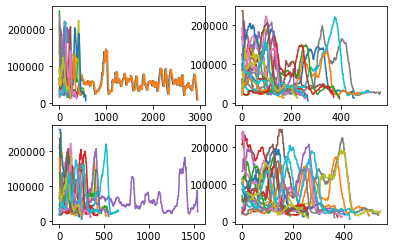

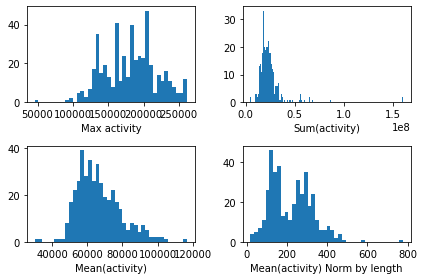

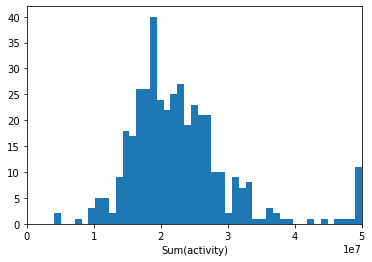

/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/4151073904.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['SmoothedActivites'] = tempSeries.map(SmoothedActivites)


In [21]:
def ReturnMotifLocations(currentDF, motif,column='Seq'):
    tempcol = []
    for seq in currentDF[column]:
        hits = re.search(motif,seq)
        if hits:
            tempcol.append(hits.start())
        else:
            tempcol.append(-1)
    return tempcol
FullOrthoDF['WxxLF_loc'] = ReturnMotifLocations(FullOrthoDF,'W.[SPA]LF',column='Seq')

SmoothedActivites = defaultdict()
maxes=[]
sums=[]
avgs,normbylengavg =[],[]
for j, species in enumerate(Orthologs_DF.SpeciesNames.unique()):
    indx = (Orthologs_DF.SpeciesNames==species)
    tempDF = Orthologs_DF[indx]
    tempMatrix = np.zeros((len(tempDF)+1,max(tempDF.NativeLocation)+20))
#     print(tempMatrix.shape)
    k =0
    for i, tile in tempDF.iterrows():
        tempMatrix[k,tile.NativeLocation-20:tile.NativeLocation+20]= tile.Activity
        k+=1
        
    tempMatrix = tempMatrix.astype('float')
    tempMatrix[tempMatrix==0]=np.nan
    tempSmoothTrace = np.nanmean(tempMatrix,axis=0)
    SmoothedActivites[species] = tempSmoothTrace
    maxes.append(max(tempSmoothTrace))
    sums.append(np.sum(tempSmoothTrace))
    avgs.append(np.mean(tempSmoothTrace))
    normbylengavg.append(np.mean(tempSmoothTrace)/len(tempSmoothTrace))
    if j <80:
        plt.subplot(2,2,j%4+1)
        plt.plot(tempSmoothTrace)
    
#         print(tempMatrix.shape)
plt.show()

plt.subplot(2,2,1)
plt.hist(maxes,40), plt.xlabel('Max activity')
plt.subplot(2,2,2)
plt.hist(sums,200), plt.xlabel('Sum(activity)')
plt.subplot(2,2,3)
plt.hist(avgs,40) , plt.xlabel('Mean(activity)')
plt.subplot(2,2,4)
plt.hist(normbylengavg,40), plt.xlabel('Mean(activity) Norm by length')
plt.tight_layout()
plt.show()

bins = np.linspace(0,5e7,50)
bins[-1] = 1.6e8
plt.hist(sums,bins), plt.xlabel('Sum(activity)')
plt.xlim([0,5e7])
plt.show()

tempSeries = FullOrthoDF.SpeciesName
FullOrthoDF['SmoothedActivites'] = tempSeries.map(SmoothedActivites)


# 20220607 I checked that the average activity at each position is being calculated correctly. Downloaded last one and calculated smoothing by hand  in numbers.

In [22]:
# add sequence properties to Full length ortholog DF
Netcharge = []
hydrophobicities = []
# PhosCharge #TO DO add net charge assuming all STY are phosphorylated
for line in FullOrthoDF.Seq: # This analysis includes the leading 'M' from the start codon
    seq =  SequenceParameters(line)
    Netcharge.append(seq.get_linear_NCPR()[1])
    hydrophobicities.append(seq.get_linear_hydropathy()[1])
    
    
FullOrthoDF['LinearCharge']=Netcharge
FullOrthoDF['LinearHydrophobicityKD']=hydrophobicities



/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/4259113159.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['LinearCharge']=Netcharge
/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/4259113159.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['LinearHydrophobicityKD']=hydrophobicities


In [23]:
# Looks like the 'true' WxxLf motif has degraded in these species and a second one has emerged
names  = ['Blastocladiomycota_jgi|Catan2|1097078|CE97078_6759', # loc = 266 indx = 236
          'Blastocladiomycota_jgi|Catan2|1466814|fgenesh1_pg.199_#_9', #loc = 237 indx = 235
          'Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g' #loc = 246 #indx = 233
         ]
# fix the WxxLF motif location of these species
FullOrthoDF.loc[236,'WxxLF_loc']=266
FullOrthoDF.loc[235,'WxxLF_loc']=237
FullOrthoDF.loc[233,'WxxLF_loc']=246

# Do Loess smoothening.


659
2928


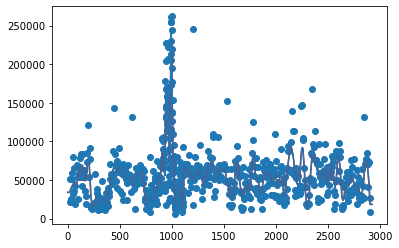


206
455


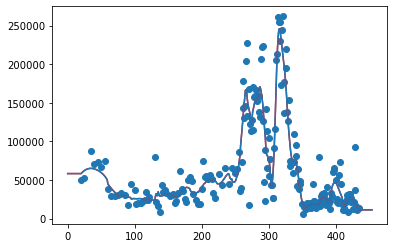


141
222


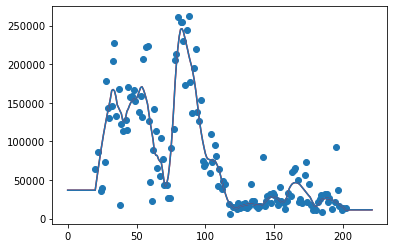


149
243


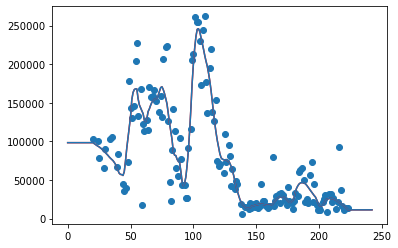


660
2943


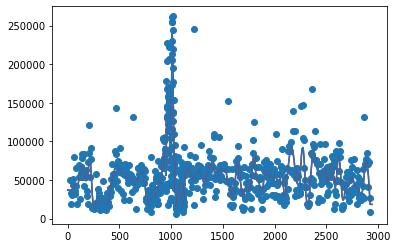


101
170


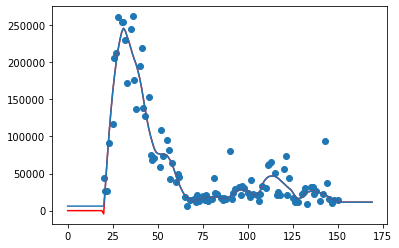


228
520


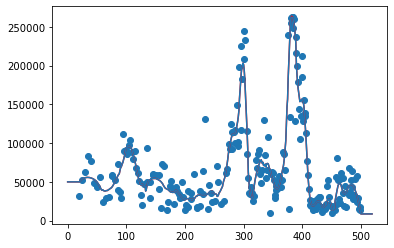


220
499


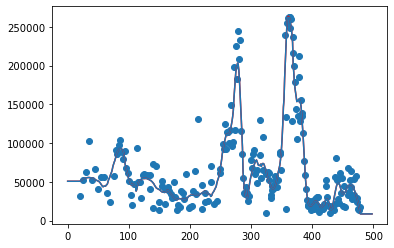


231
534


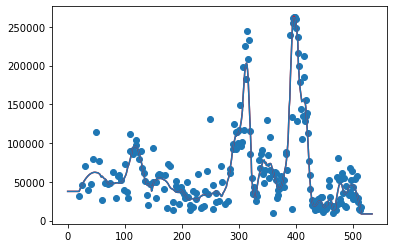


91
173


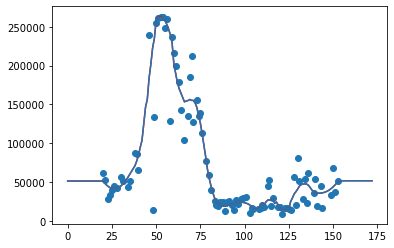


130
239


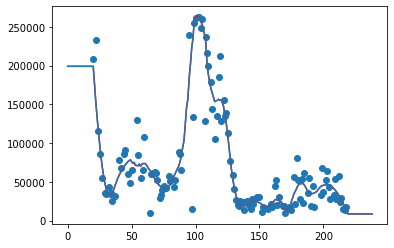


141
257


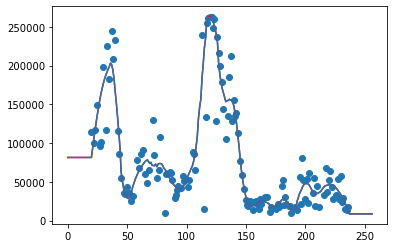


104
191


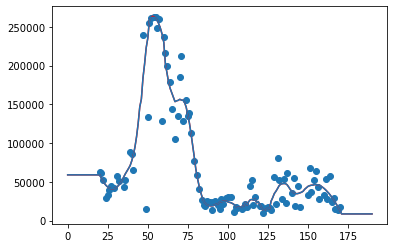


144
262


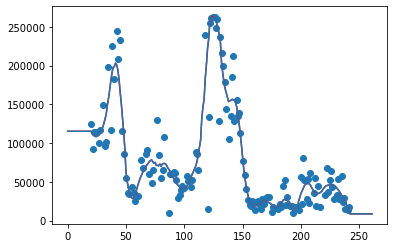


166
429


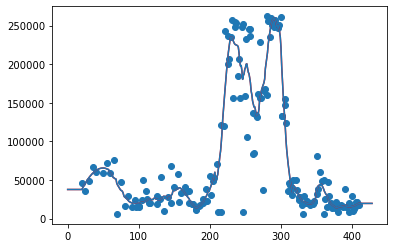

In [24]:
# Do Loess smoothening.
import loess
from loess import loess_1d
SmoothedActivitesLoess = defaultdict()
maxActivity = max(masterDF.Activity_SCglucose)
minActivity = min(masterDF[masterDF.Recovered].Activity_SCglucose)
OrthologLengths = dict(zip(FullOrthoDF.SpeciesName,FullOrthoDF.Length))
for i, species in enumerate((FullOrthoDF['SpeciesName'])): # for each TF
    indx = (Orthologs_DF['SpeciesNames']==species)&(Orthologs_DF['Activity']>0) # pull out all tiles for that TF
    tempDF = Orthologs_DF[indx]
    tempDF =tempDF.sort_values(by = 'NativeLocation',ascending=True)
    X =tempDF.NativeLocation.values
    Y =tempDF.Activity.values
    xout, yout, wout = loess.loess_1d.loess_1d(X, Y, xnew=range(OrthologLengths[species]), degree=2, 
                            npoints=20, rotate=False, sigy=None)
                            #Nick you might want degree=1, which is first order polynomial spline fitting
                            #npoints means use the 20 closest tiles in either direction, but weight them by distance. 
                                # I messed around with this by hand. 
    # correct the first 20 and last 20 entries in the output
    
    # This manual correction for the ends is because the 2nd order polynomial can go negative or shoot to big numbers.
    modyout = yout
    start = max(yout[20],0)
    modyout[0:20] = start
    end = max(yout[-20],0)
    modyout[-20:] = end
    modyout2 = np.clip(modyout,a_min=minActivity,a_max=maxActivity)
    SmoothedActivitesLoess[species] = modyout2
    if i < 15:
        print()
        print(len(X))
        print(len(xout))

        
        plt.scatter(X,Y)
        plt.plot(xout,yout,c='r')
        plt.plot(xout,modyout2)
#         plt.ylim(0,maxActivity)
        plt.show()
tempSeries = FullOrthoDF.SpeciesName


In [25]:
FullOrthoDF['SmoothedActivitesLoess'] = tempSeries.map(SmoothedActivitesLoess)


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_33931/3595736009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['SmoothedActivitesLoess'] = tempSeries.map(SmoothedActivitesLoess)


In [26]:
# FullOrthoDF.to_pickle('../Data/Processed/FullOrthologDF_20230414')
# FullOrthoDF.to_csv('../Data/Processed/FullOrthologDF_20230414.csv')
FullOrthoDF.to_pickle('../Data/Processed/FullOrthologDF_20240930')
FullOrthoDF.to_csv('../Data/Processed/FullOrthologDF_20240930.csv')



0.6366993137001264


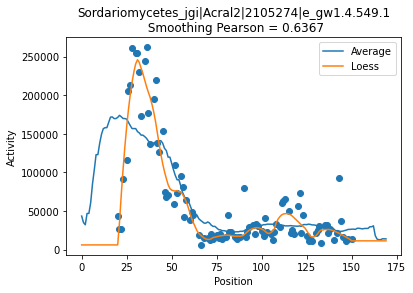

0.7311950557497467


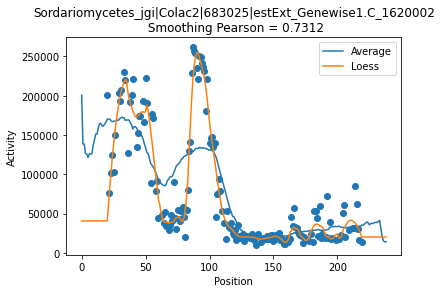

0.7348526520919153


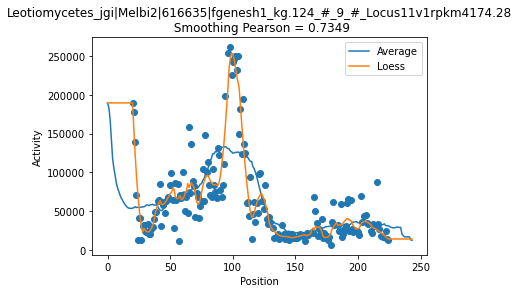

0.6935903740099577


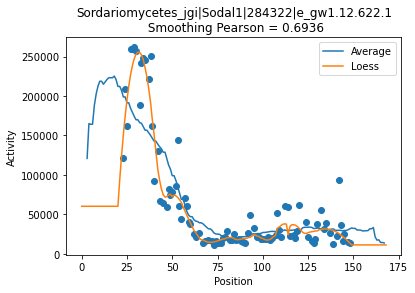

0.9905837560718888


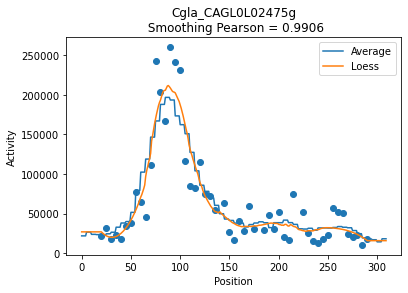

0.9947326021765944


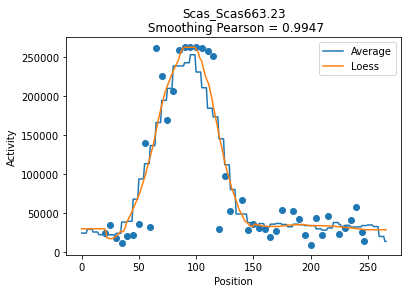

0.9931082745235443


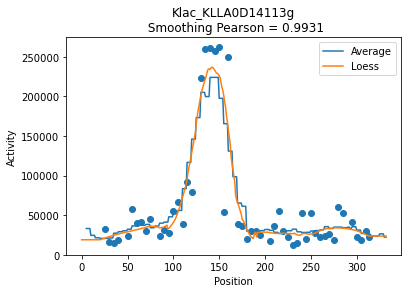

0.994296243563506


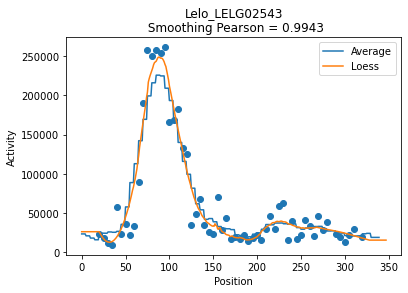

0.9902548993042503


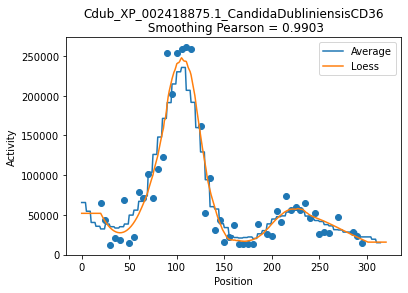

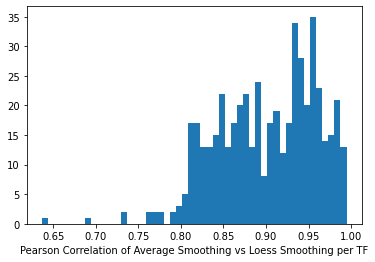

In [27]:
# FullOrthoDF.plot.scatter(x='SmoothedActivites',y='SmoothedActivitesLoess')
goodthresh = .99 #if more than this pearson, save figure as a example of Good Correlation
badthersh = .75 #if less than this pearson, save figure as a example of Poor Correlation
import numpy.ma as ma
corrs =[]
for i, line in FullOrthoDF.iterrows():
#     if i <10:
#         print(min(line.SmoothedActivites))
#         print(min(line.SmoothedActivitesLoess))
#         plt.scatter(line.SmoothedActivites,line.SmoothedActivitesLoess)
#         plt.xlabel('Smoothen with Average'),plt.ylabel('Smoothen with Loess')    
#         plt.show()
    A =line.SmoothedActivites
    B = line.SmoothedActivitesLoess
    a=ma.masked_invalid(A)
    b=ma.masked_invalid(B)
    msk = (~a.mask & ~b.mask)
    corr = ma.corrcoef(a[msk],b[msk])
#     ma.corrcoef(ma.masked_invalid(a), ma.masked_invalid(b))
    corrs.append(corr.data[0,1])
    if (corr.data[0,1] < badthersh)|(corr.data[0,1] >goodthresh):
        print(corr.data[0,1])
#         print(min(line.SmoothedActivitesLoess))
#         plt.scatter(line.SmoothedActivites,line.SmoothedActivitesLoess)
#         plt.xlabel('Smoothen with Average'),plt.ylabel('Smoothen with Loess')    , plt.legend()
# 
        plt.plot(range(len(line.SmoothedActivites)),line.SmoothedActivites,label='Average')
        plt.plot(range(len(line.SmoothedActivitesLoess)),line.SmoothedActivitesLoess,label='Loess')
        indx = (Orthologs_DF['SpeciesNames']==line.SpeciesName)&(Orthologs_DF['Activity']>0)
        tempDF = Orthologs_DF[indx]
        tempDF =tempDF.sort_values(by = 'NativeLocation',ascending=True)
        X =tempDF.NativeLocation.values
        Y =tempDF.Activity.values
        plt.scatter(X,Y,label='')
        plt.xlabel('Position'),plt.ylabel('Activity')    , plt.legend()
        plt.title('%s\n Smoothing Pearson = %.4f'%(line.SpeciesName,corr.data[0,1]))
        if (corr.data[0,1] < badthersh):
            plt.savefig('Figures/PaperFigs/Controls/Smoothing/Bad/CompareSmoothening_%s.pdf'%line.SpeciesName)
        if (corr.data[0,1] > goodthresh):
            plt.savefig('Figures/PaperFigs/Controls/Smoothing/Good/CompareSmoothening_%s.pdf'%line.SpeciesName)
        
        plt.show()
plt.hist(corrs,50)
plt.xlabel('Pearson Correlation of Average Smoothing vs Loess Smoothing per TF')
plt.savefig('Figures/PaperFigs/Controls/Smoothing/Control_Smoothing_Correlate_LoessWithAveraging.pdf')
plt.show()

Text(0.5, 0, 'Correlation between Average Smoothing and Loess Smoothing per TF')

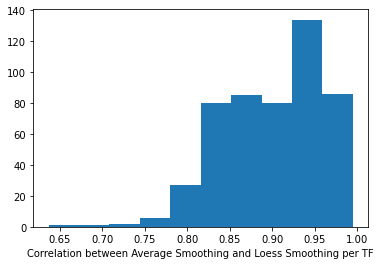

In [28]:
import scipy
corrs = []
for species in FullOrthoDF.SpeciesName:
    a = SmoothedActivites[species]
    b = SmoothedActivitesLoess[species]
    indx =( ~np.isnan(a))&(~np.isnan(b))
    a = a[indx]
    b = b[indx]
#     print(len(a))
#     print(len(b))
#     print()
    corr = scipy.stats.pearsonr(a,b)
    corrs.append(corr[0])
plt.hist(corrs)
plt.xlabel('Correlation between Average Smoothing and Loess Smoothing per TF')